# Model Selection

## Importing Libraries

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
from datetime import date
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# %load_ext nb_black

# Defaults
plt.rcParams["figure.figsize"] = (20.0, 10.0)
plt.rcParams.update({"font.size": 12, "figure.dpi": 120})
# pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")  # specify to ignore warning messages

## Data Handling

In [2]:
def preprocess(df):
    df = df.drop(["Lat", "Long"], axis=1)
    df = df.groupby(["Country/Region"], as_index=False).sum()
    df.loc[-1] = df.sum()
    df.loc[-1, "Country/Region"] = "Worldwide"
    countries = [
        "US",
        "Germany",
        "Spain",
        "United Kingdom",
        "France",
        "India",
        "Iran",
        "Italy",
        "Russia",
        "Turkey",
        #         "Worldwide",
    ]
    df = df.loc[df["Country/Region"].isin(countries)]
    df.reset_index(drop=True, inplace=True)
    df = df.set_index("Country/Region")
    df.columns = pd.to_datetime(df.columns)
    df = df.T
    return df

In [3]:
confirmed_df = pd.read_csv(
    "./csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
)
confirmed_df = preprocess(confirmed_df)
deaths_df = pd.read_csv(
    "./csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
)
deaths_df = preprocess(deaths_df)
recovered_df = pd.read_csv(
    "./csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
)
recovered_df = preprocess(recovered_df)

In [4]:
active_df = pd.DataFrame(confirmed_df - deaths_df - recovered_df)
#active_df.plot(figsize=(15, 5))
#plt.show()

In [5]:
#confirmed_df.plot(figsize=(15, 5))
#plt.show()

In [6]:
#deaths_df.plot(figsize=(15, 5))
#plt.show()

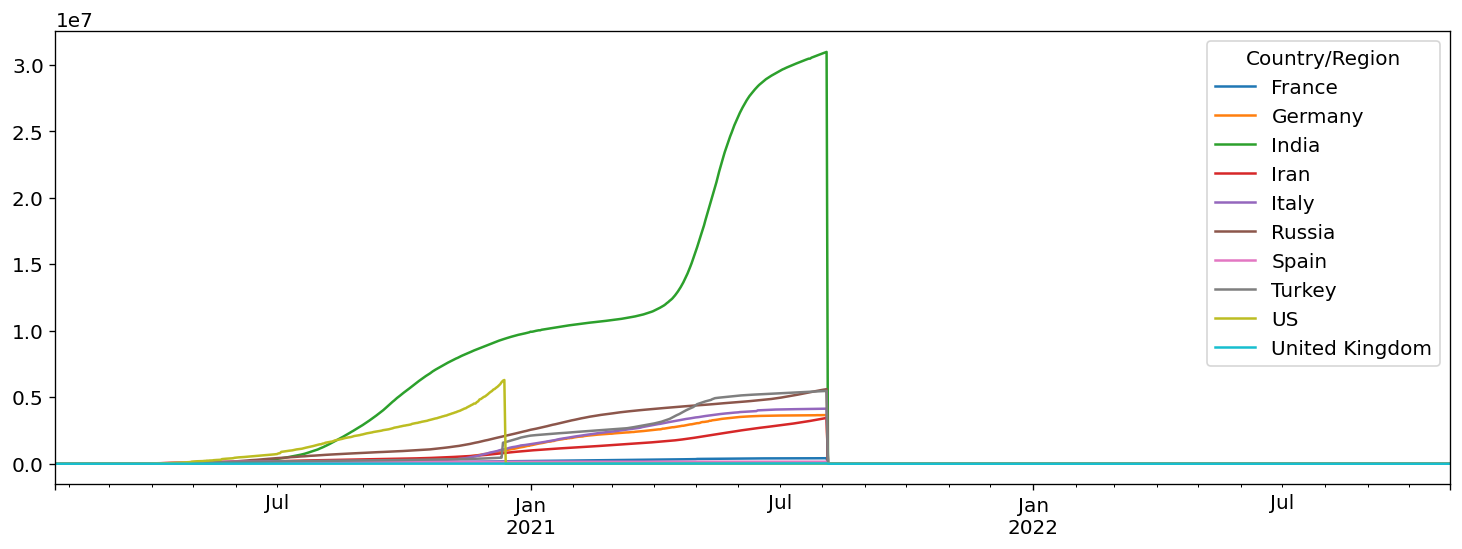

In [7]:
recovered_df.plot(figsize=(15, 5))
plt.show()

In [8]:
recovered_df['2021-05-07':'2021-05-31']

Country/Region,France,Germany,India,Iran,Italy,Russia,Spain,Turkey,US,United Kingdom
2021-05-07,369898,3142640,17930960,2074089,3572713,4429201,150376,4662328,0,14961
2021-05-08,371076,3160630,18317364,2092381,3590107,4437289,150376,4691224,0,15011
2021-05-09,371478,3187100,18671222,2109702,3604523,4444712,150376,4716918,0,15011
2021-05-10,372400,3188710,19027304,2127192,3619586,4451443,150376,4743871,0,15088
2021-05-11,373975,3231090,19382642,2144197,3636089,4458408,150376,4766124,0,15147
2021-05-12,375465,3233630,19734823,2162087,3655112,4466782,150376,4801291,0,15158
2021-05-13,376532,3268190,20079599,2179890,3669407,4475999,150376,4856763,0,15201
2021-05-14,377338,3284300,20432898,2196197,3683189,4485592,150376,4894024,0,15214
2021-05-15,378643,3292700,20795335,2210851,3696481,4495406,150376,4932838,0,15254
2021-05-16,378958,3306260,21174076,2226122,3706084,4503945,150376,4947256,0,15258


### Train test split

In [9]:
#active_train = active_df["2020-01-22":"2021-04-22"]
active_train = active_df["2020-02-04":"2021-08-04"]
active_test = active_df["2021-04-23":"2021-04-08"]
confirmed_train = confirmed_df["2020-01-22":"2021-04-22"]
confirmed_test = confirmed_df["2021-04-23":"2021-04-08"]

## Model Selection

### Determining order of differencing (d)

In [10]:
# Original Series
country = "India"
df = pd.DataFrame((active_train[country].to_numpy()), columns = {'cases'})

In [11]:
result = adfuller(df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.440185
p-value: 0.130714
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


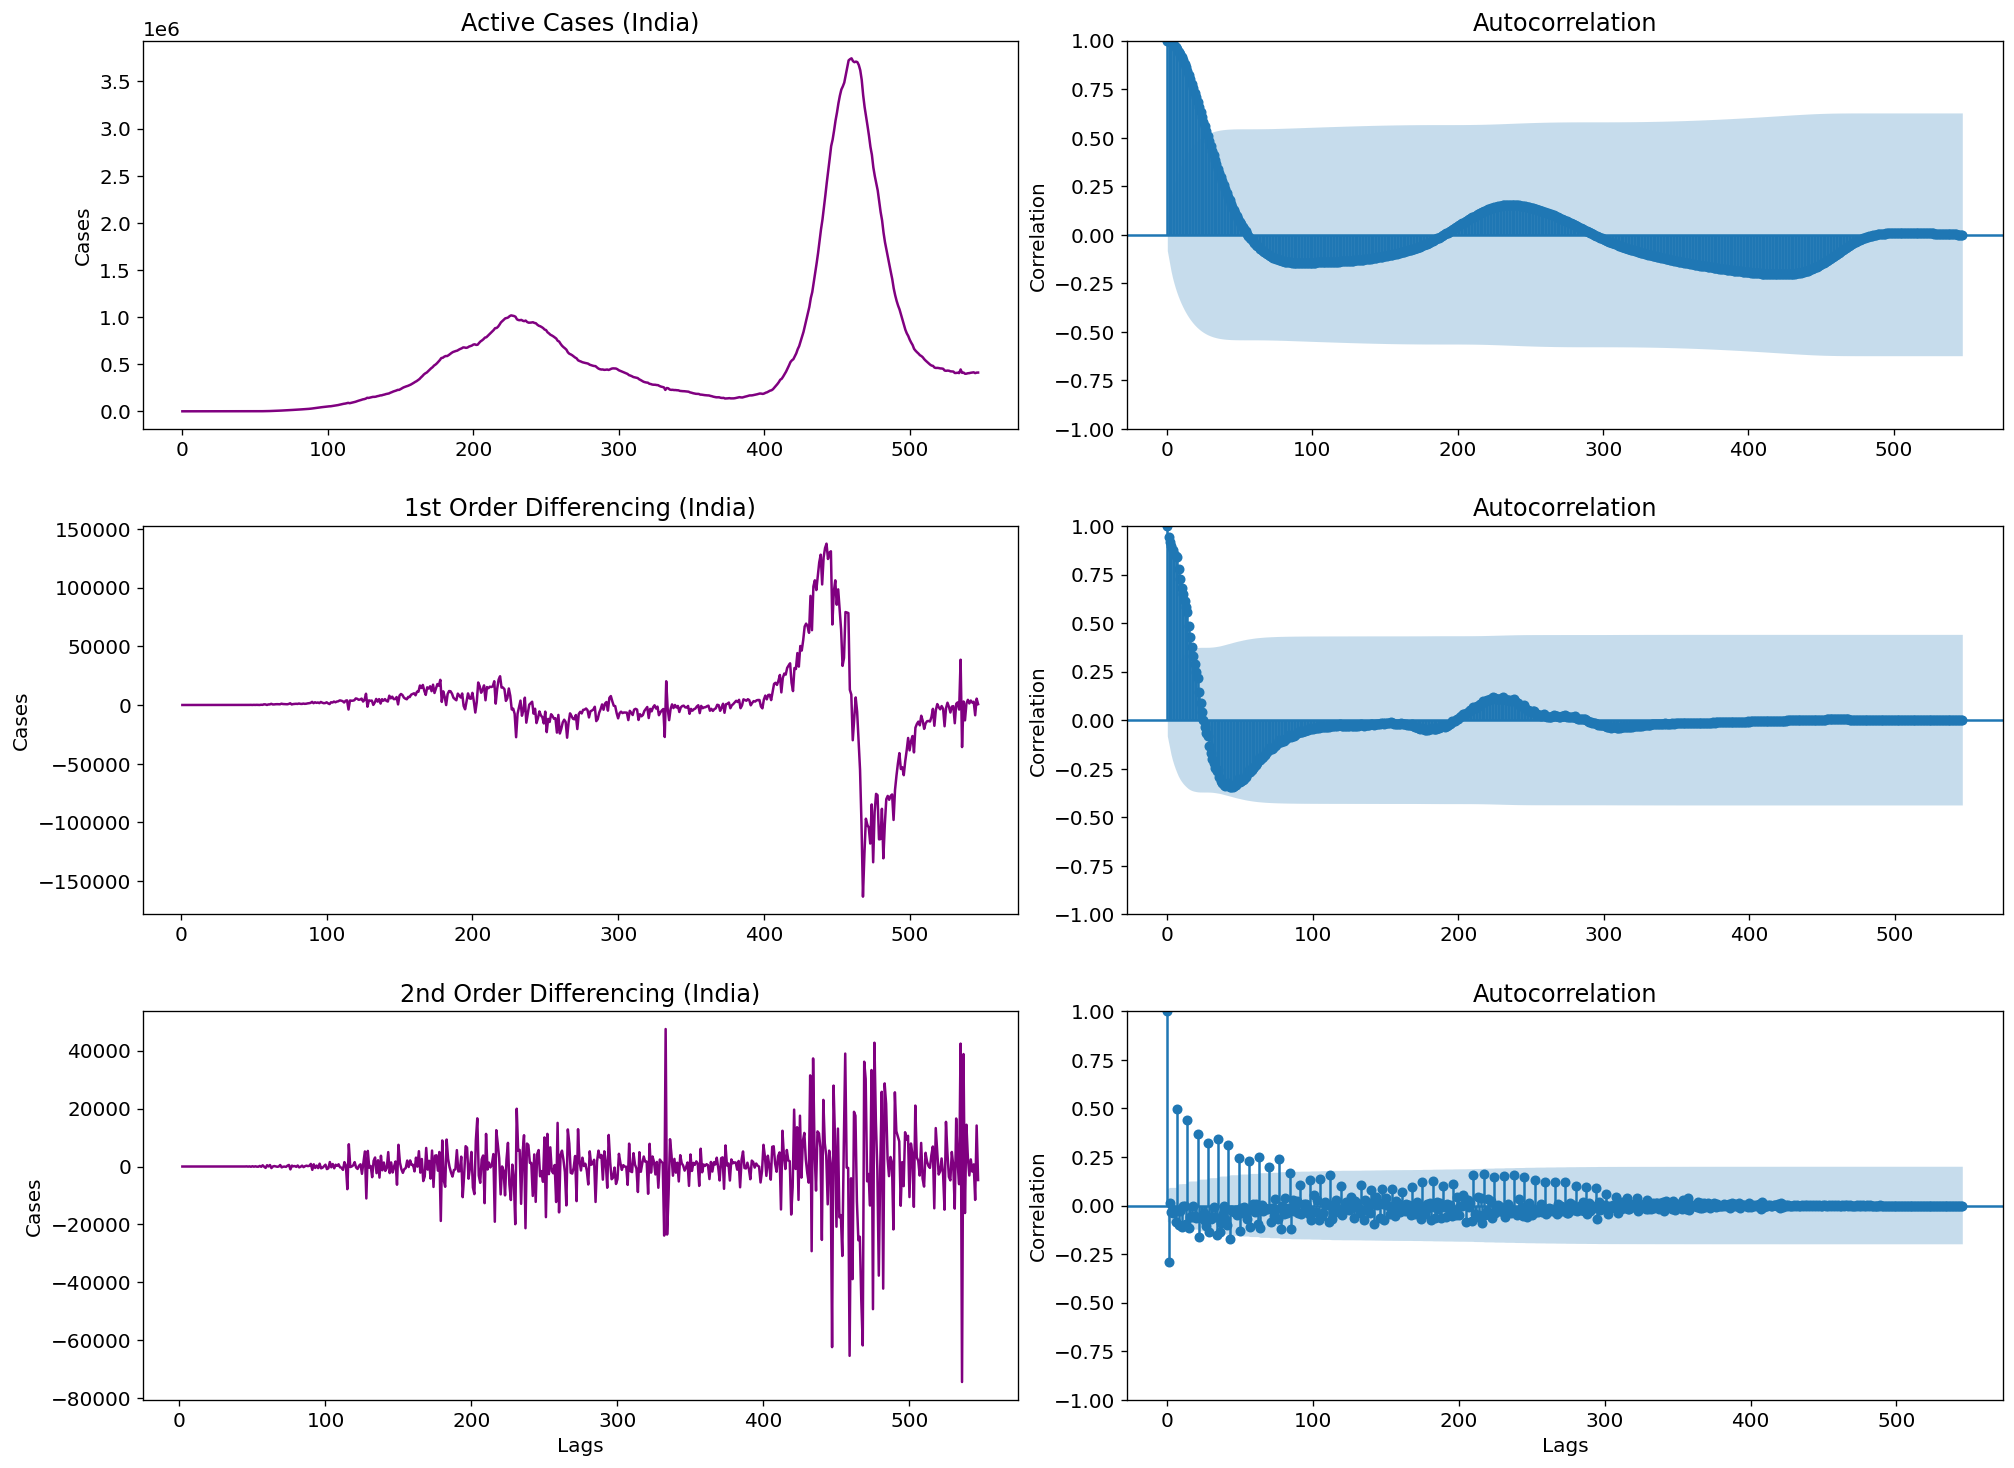

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.subplots_adjust(hspace=0.250, wspace=0.125)
axes[0, 0].plot(df, "purple")
axes[0, 0].set(title=f"Active Cases ({country})", ylabel="Cases")
plot_acf(df, ax=axes[0, 1], lags=df.shape[0] - 1)
axes[0, 1].set(ylabel="Correlation")

# 1st Differencing
axes[1, 0].plot(df.diff(), "purple")
axes[1, 0].set(title=f"1st Order Differencing ({country})", ylabel="Cases")
plot_acf(df.diff().dropna(), ax=axes[1, 1], lags=df.shape[0] - 2)
axes[1, 1].set(ylabel="Correlation")


# 2nd Differencing
axes[2, 0].plot(df.diff().diff(), "purple")
axes[2, 0].set(
    xlabel="Lags", ylabel="Cases", title=f"2nd Order Differencing ({country})"
)
axes[2, 1].set_xlabel("Lags")
plot_acf(df.diff().diff().dropna(), ax=axes[2, 1], lags=df.shape[0] - 3)
axes[2, 1].set(ylabel="Correlation")

fig.savefig("Graphs/1.acf_plots.jpg")
plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the second differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.
$$d = 1 $$

### Determining order of Auto-Regression (p)

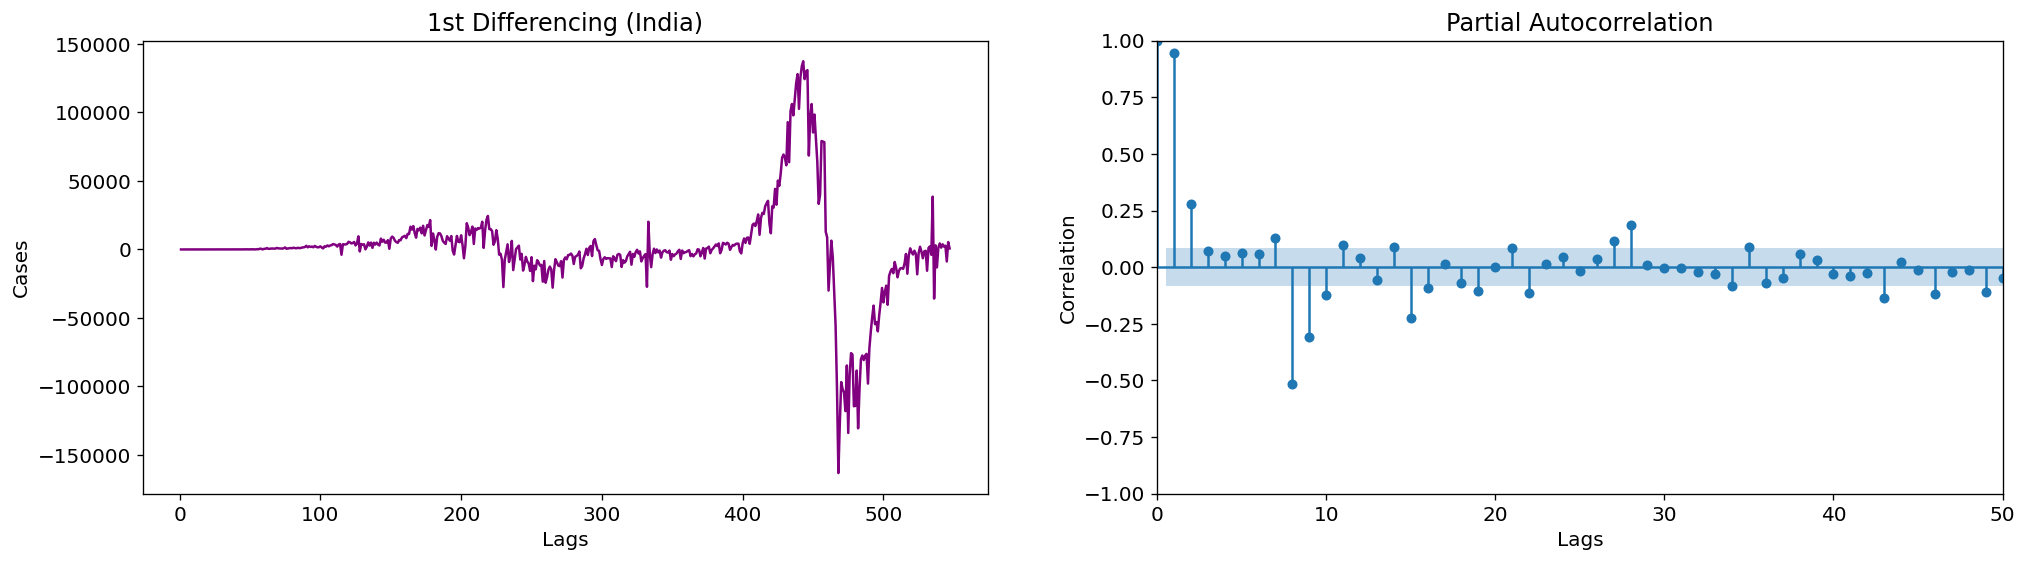

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(df.diff(), "purple")
ax1.set(title=f"1st Differencing ({country})", xlabel="Lags", ylabel="Cases")
plot_pacf(df.diff().dropna(), ax=ax2, lags=272)
ax2.set(xlabel="Lags", ylabel="Correlation", ylim=(-1, 1), xlim=(0, 50))
fig.savefig("Graphs/2.pacf_plots.jpg")
plt.show()

It can observed that the PACF lag 1, 2 and 3 are quite significant since they are well above the significance limit, the blue region.
So we will use:
$$p \in \{1, 2, 3\}$$

### Determining order of Moving Average (q)

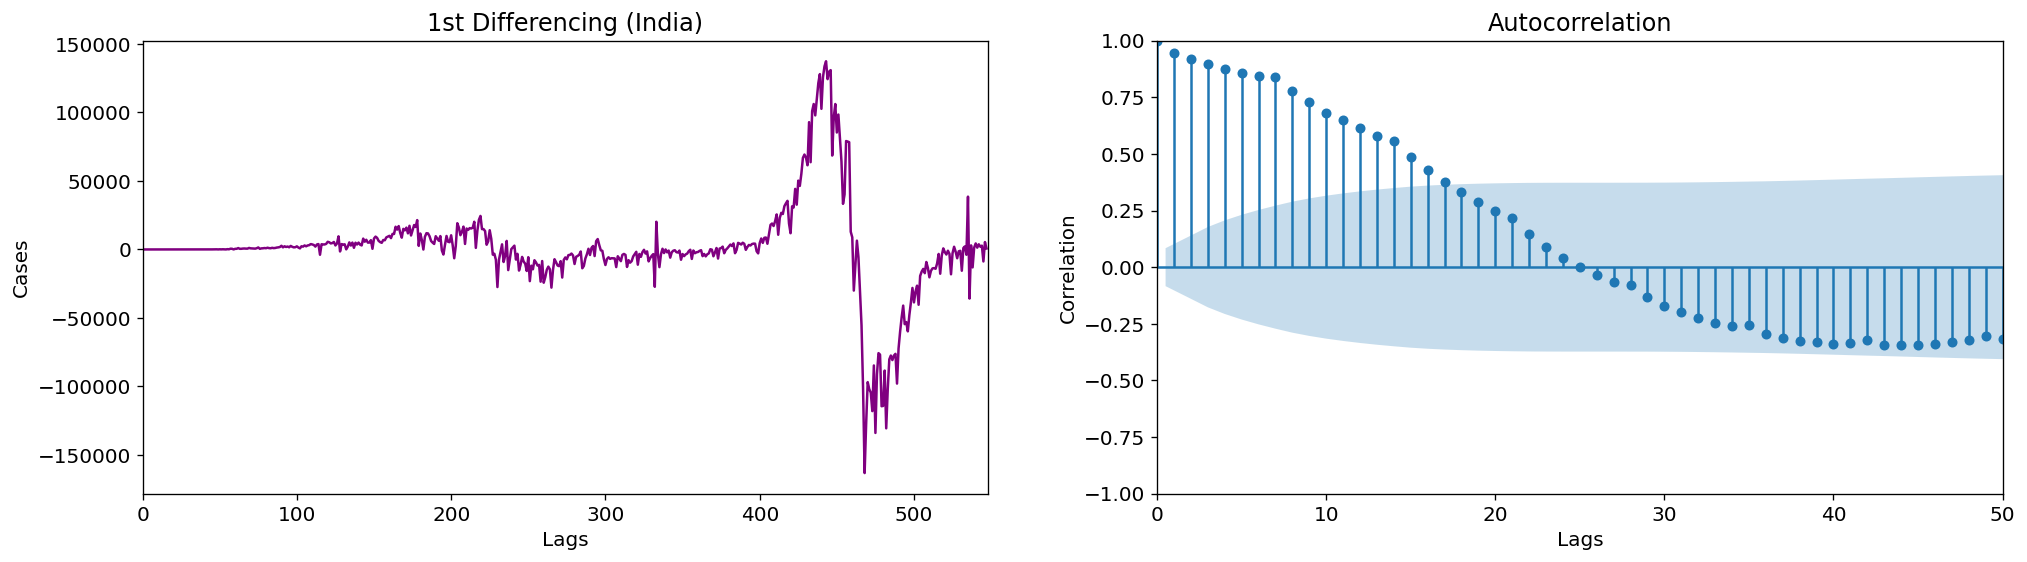

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].plot(df.diff(), "purple")
axes[0].set(
    title=f"1st Differencing ({country})",
    xlabel="Lags",
    ylabel="Cases",
    xlim=(0, df.shape[0]),
)
plot_acf(df.diff().dropna(), ax=axes[1], lags=df.shape[0] - 2)
axes[1].set(ylim=(-1, 1), xlim=(0, 50), xlabel="Lags", ylabel="Correlation")

fig.savefig("Graphs/3.acf_plots.jpg")
plt.show()

We can see that upto `lags` = 9, the correlation is above the significance range and so we can conclude that: $$q \in [1, 9]$$

In [15]:
# Define the p, d, q parameters
p = range(1, 4)
d = 1
q = range(1, 10)

In [18]:
import pmdarima as pm

model = pm.auto_arima(df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=12501.458, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=16701.073, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=11731.644, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=11782.304, Time=0.23 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=11732.804, Time=0.63 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=11732.962, Time=0.52 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=12241.485, Time=1.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=11738.518, Time=0.22 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.46 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=11726.612, Time=0.54 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=12658.394, Time=0.40 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=11781.038, Time=0.25 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   :

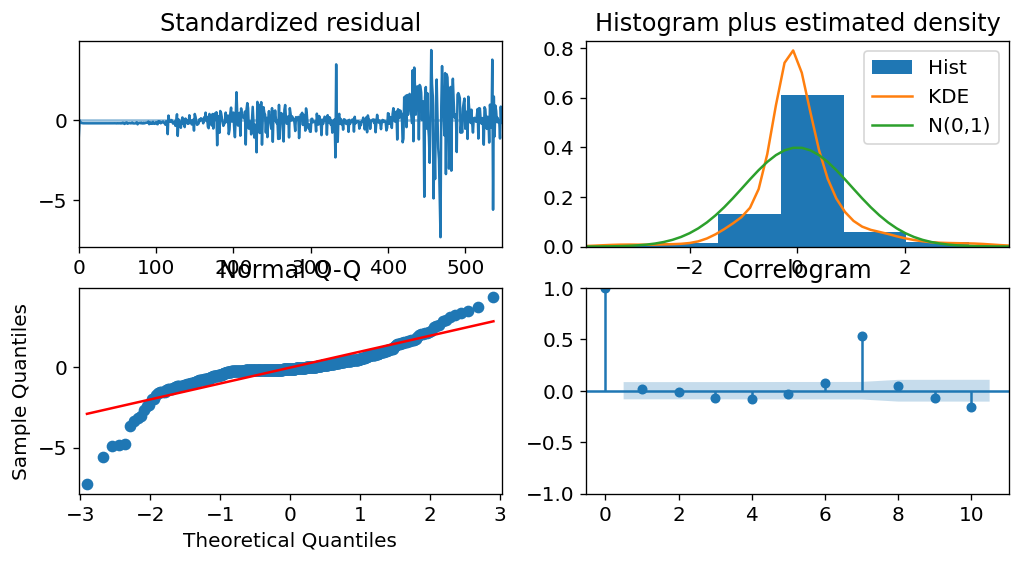

In [19]:
model.plot_diagnostics(figsize=(10,5))
plt.show()

                               SARIMAX Results                                
Dep. Variable:                  cases   No. Observations:                  548
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -5857.710
Date:                Fri, 02 Dec 2022   AIC                          11725.420
Time:                        11:35:36   BIC                          11746.951
Sample:                             0   HQIC                         11733.836
                                - 548                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.018e+05   3.22e-10   1.87e+15      0.000    6.02e+05    6.02e+05
ar.L1          1.9756      0.005    430.324      0.000       1.967       1.985
ar.L2         -0.9773      0.005   -212.516      0.0

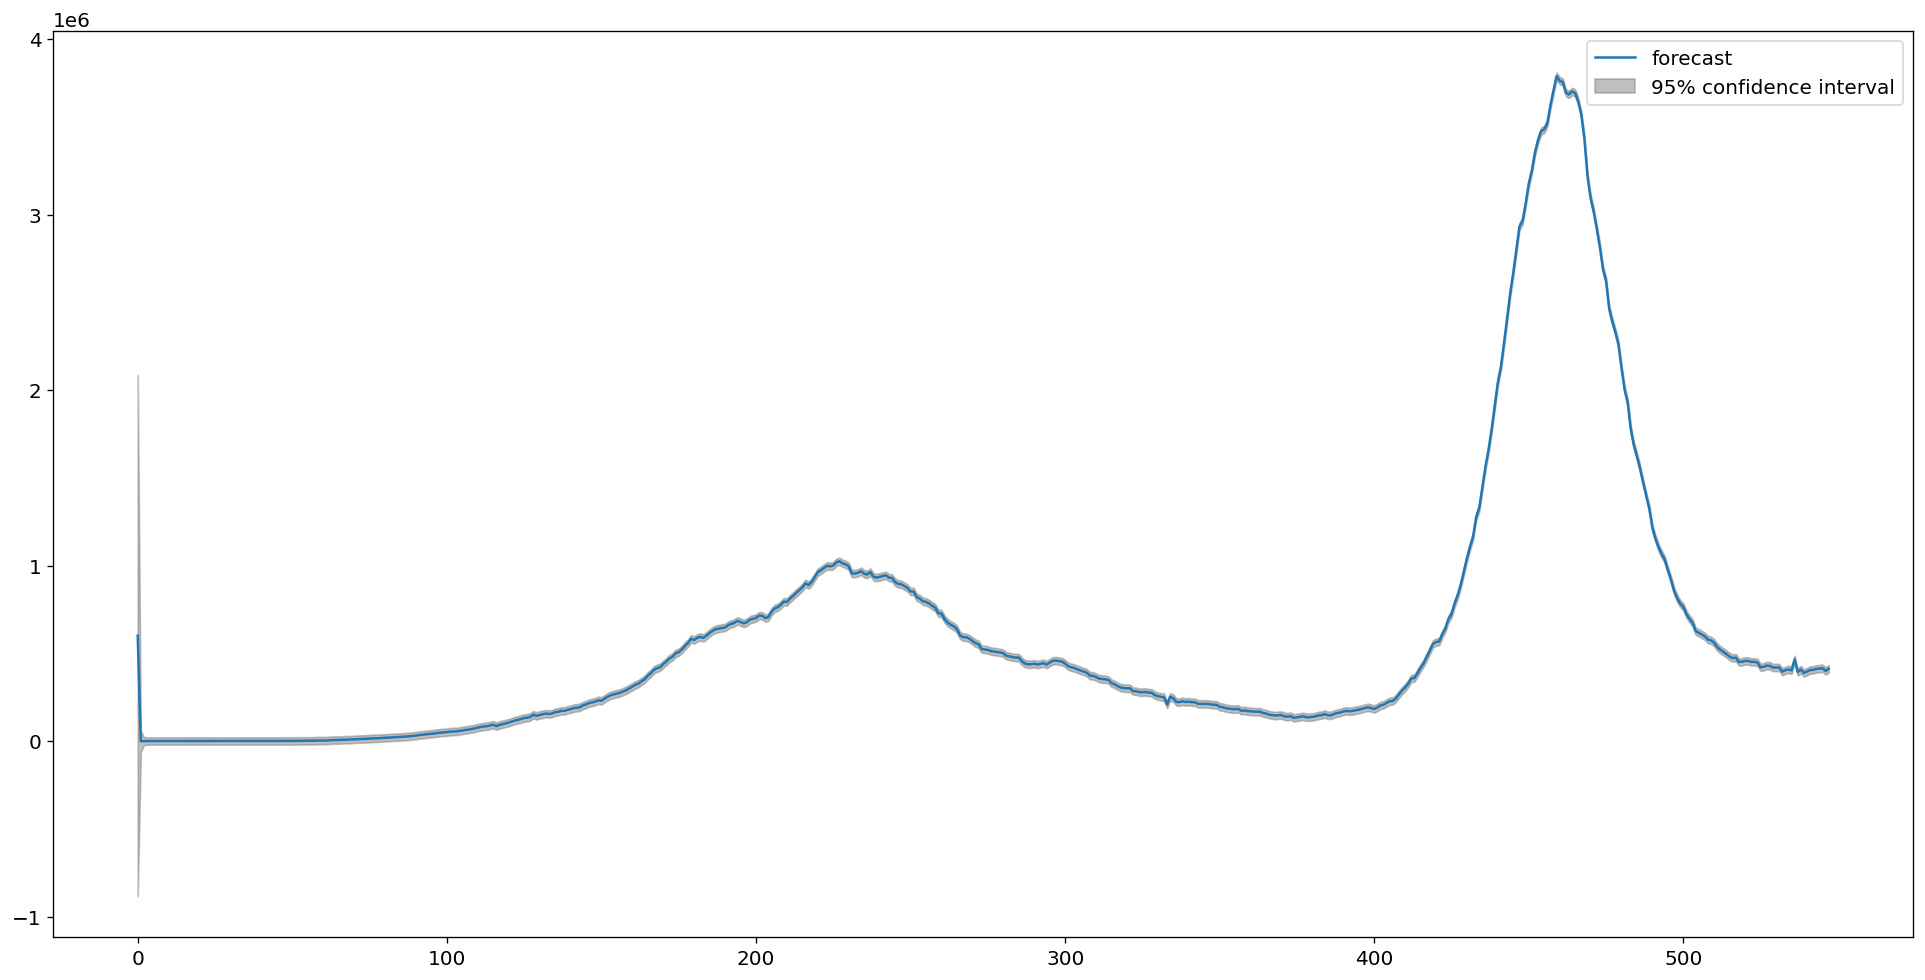

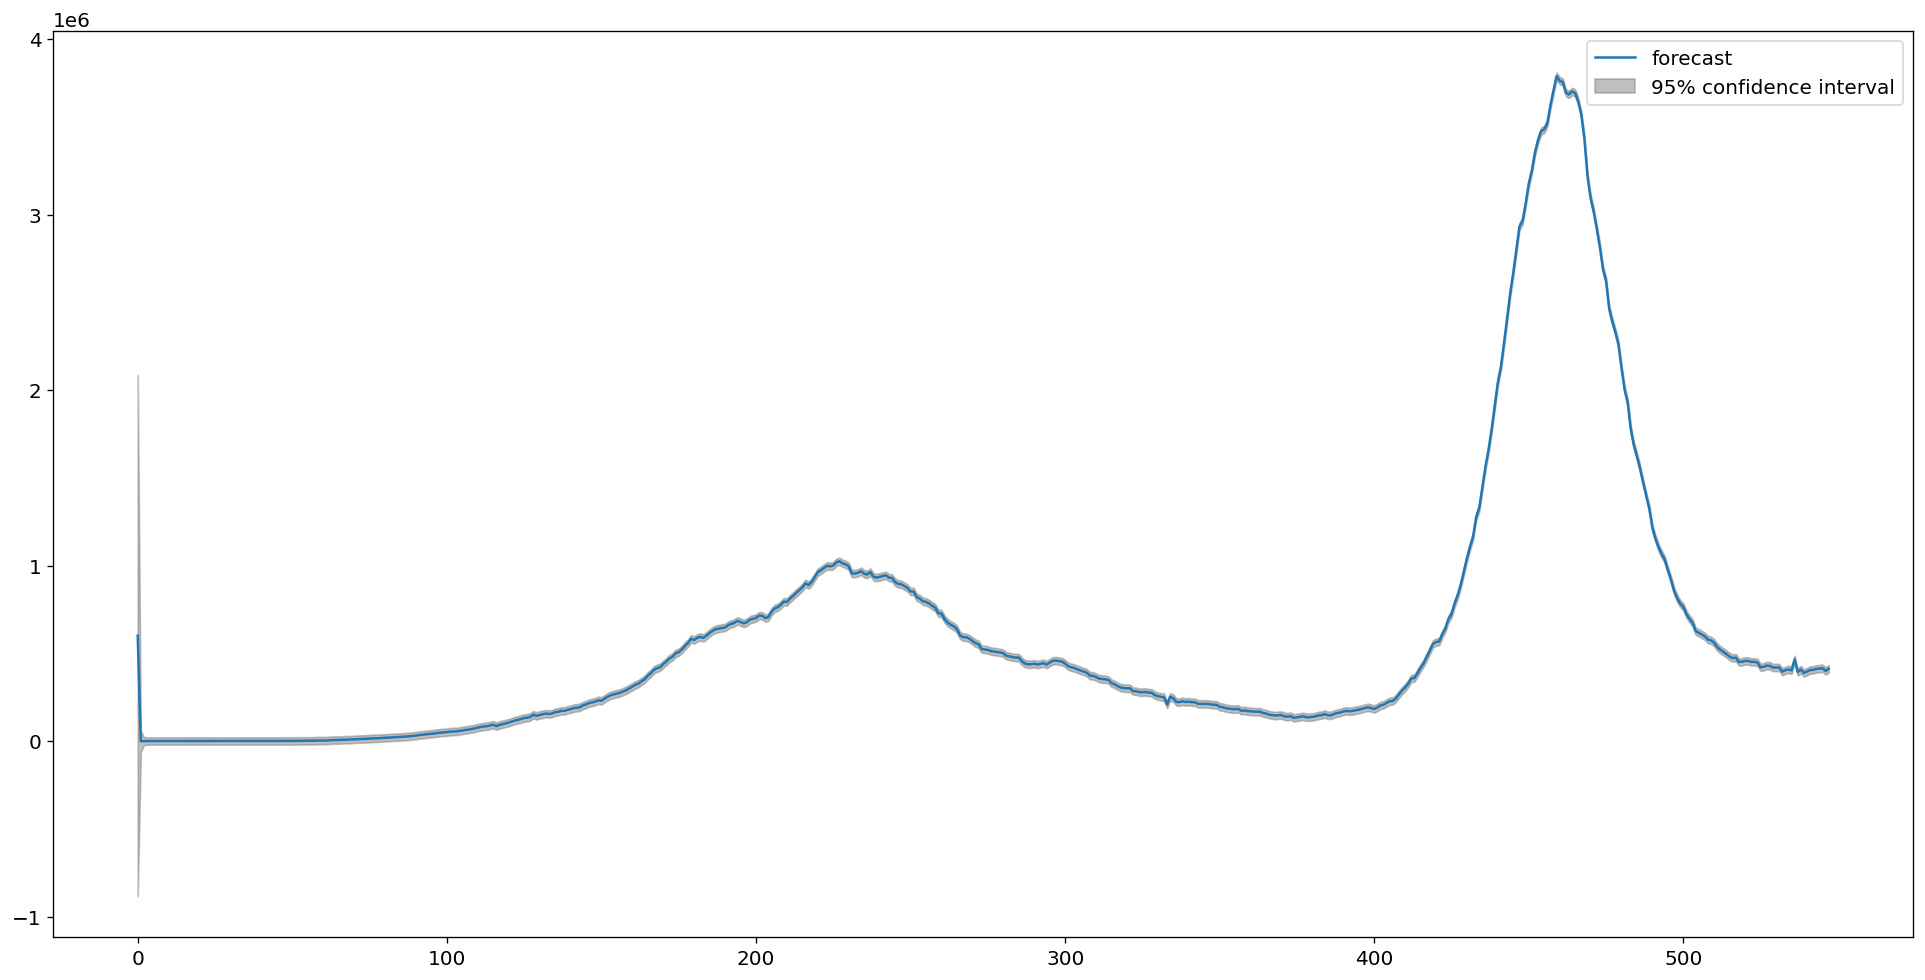

In [32]:
model = ARIMA(df, order=(2,0,1))
model_fit = model.fit()
print(model_fit.summary())
plot_predict(model_fit)

In [37]:
df.shape
help(fitted.forecast)

Help on method forecast in module statsmodels.tsa.statespace.mlemodel:

forecast(steps=1, **kwargs) method of statsmodels.tsa.arima.model.ARIMAResultsWrapper instance
    forecast(self, steps=1, **kwargs)
    
    Out-of-sample forecasts
    
    Parameters
    ----------
    steps : int, str, or datetime, optional
        If an integer, the number of steps to forecast from the end of the
        sample. Can also be a date string to parse or a datetime type.
        However, if the dates index does not have a fixed frequency, steps
        must be an integer. Default
    **kwargs
        Additional arguments may required for forecasting beyond the end
        of the sample. See `FilterResults.predict` for more details.
    
    Returns
    -------
    forecast : array_like
        Out-of-sample forecasts (Numpy array or Pandas Series or DataFrame,
        depending on input and dimensions).
        Dimensions are `(steps x k_endog)`.
    
    See Also
    --------
    predict
        I

In [70]:
model = ARIMA(df, order=(2, 0, 1))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc = fitted.forecast(100, alpha=0.05)  # 95% conf
print(fc.shape)
#Make as pandas series
fc_series = fc.to_numpy().reshape(100, -1)
# lower_series = pd.Series(conf[:, 0], index=test.index)
# upper_series = pd.Series(conf[:, 1], index=test.index)

# # Plot
# plt.figure(figsize=(12,5), dpi=100)
# plt.plot(train, label='training')
# plt.plot(test, label='actual')
# plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.15)
# plt.title('Forecast vs Actuals')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()

                               SARIMAX Results                                
Dep. Variable:                  cases   No. Observations:                  548
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -5857.710
Date:                Fri, 02 Dec 2022   AIC                          11725.420
Time:                        11:57:57   BIC                          11746.951
Sample:                             0   HQIC                         11733.836
                                - 548                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.018e+05   3.22e-10   1.87e+15      0.000    6.02e+05    6.02e+05
ar.L1          1.9756      0.005    430.324      0.000       1.967       1.985
ar.L2         -0.9773      0.005   -212.516      0.0

In [73]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
#     acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

# print (fc_series.reshape(100, -1).shape, df[-100:].to_numpy().shape)

forecast_accuracy(fc_series, df[-100:].to_numpy())


{'mape': 0.5841545511705415,
 'me': -944110.4420421618,
 'mae': 1125977.771178266,
 'mpe': -0.16734575900898296,
 'rmse': 1638899.6755399422,
 'corr': nan,
 'minmax': 0.5114876895018783}

In [21]:
print(len(df))

548


In [22]:
RMSE = []
ARIMA_model = []

mod = sm.tsa.arima.ARIMA(df, order=(11, 1, 5), enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(f"ARIMA - MSE:{results.mse}", end="\r")
RMSE.append(math.sqrt(results.mse))
# ARIMA_model.append(param)
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  cases   No. Observations:                  548
Model:                ARIMA(11, 1, 5)   Log Likelihood               -5805.469
Date:                Fri, 02 Dec 2022   AIC                          11644.937
Time:                        11:33:36   BIC                          11717.767
Sample:                             0   HQIC                         11673.430
                                - 548                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6770      0.111    -15.164      0.000      -1.894      -1.460
ar.L2          0.4835      0.123      3.947      0.000       0.243       0.724
ar.L3          1.9616      0.149     13.180      0.0

In [23]:
RMSE

[11419.838455182393]

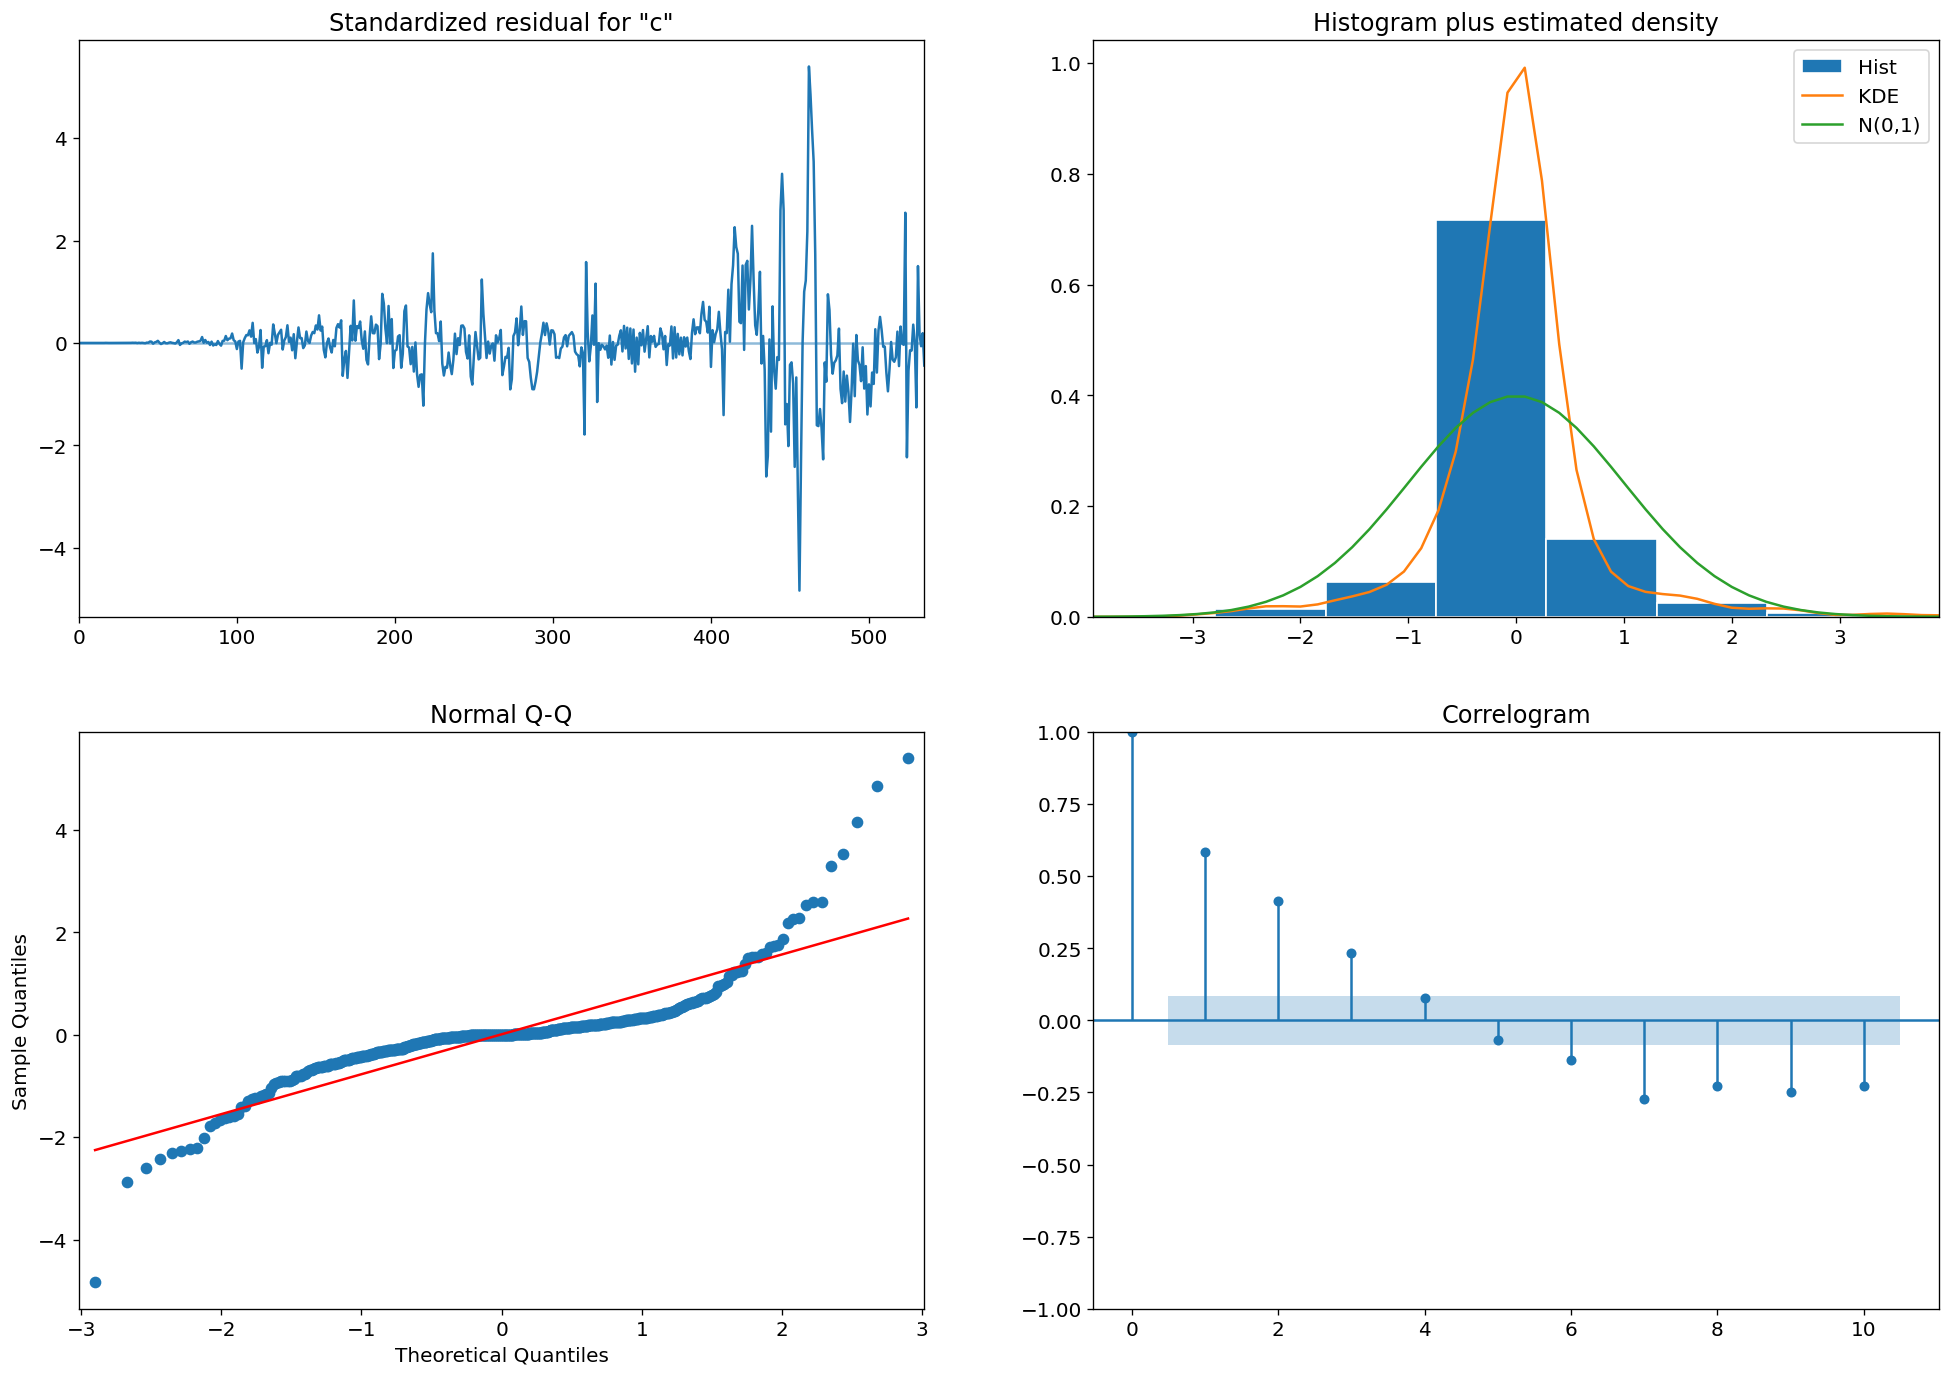

In [24]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

In [25]:
testdata = active_df["2020-01-22":"2021-04-22"]
testdf = pd.DataFrame((testdata['India'].to_numpy()), columns = {'cases'})

<AxesSubplot:>

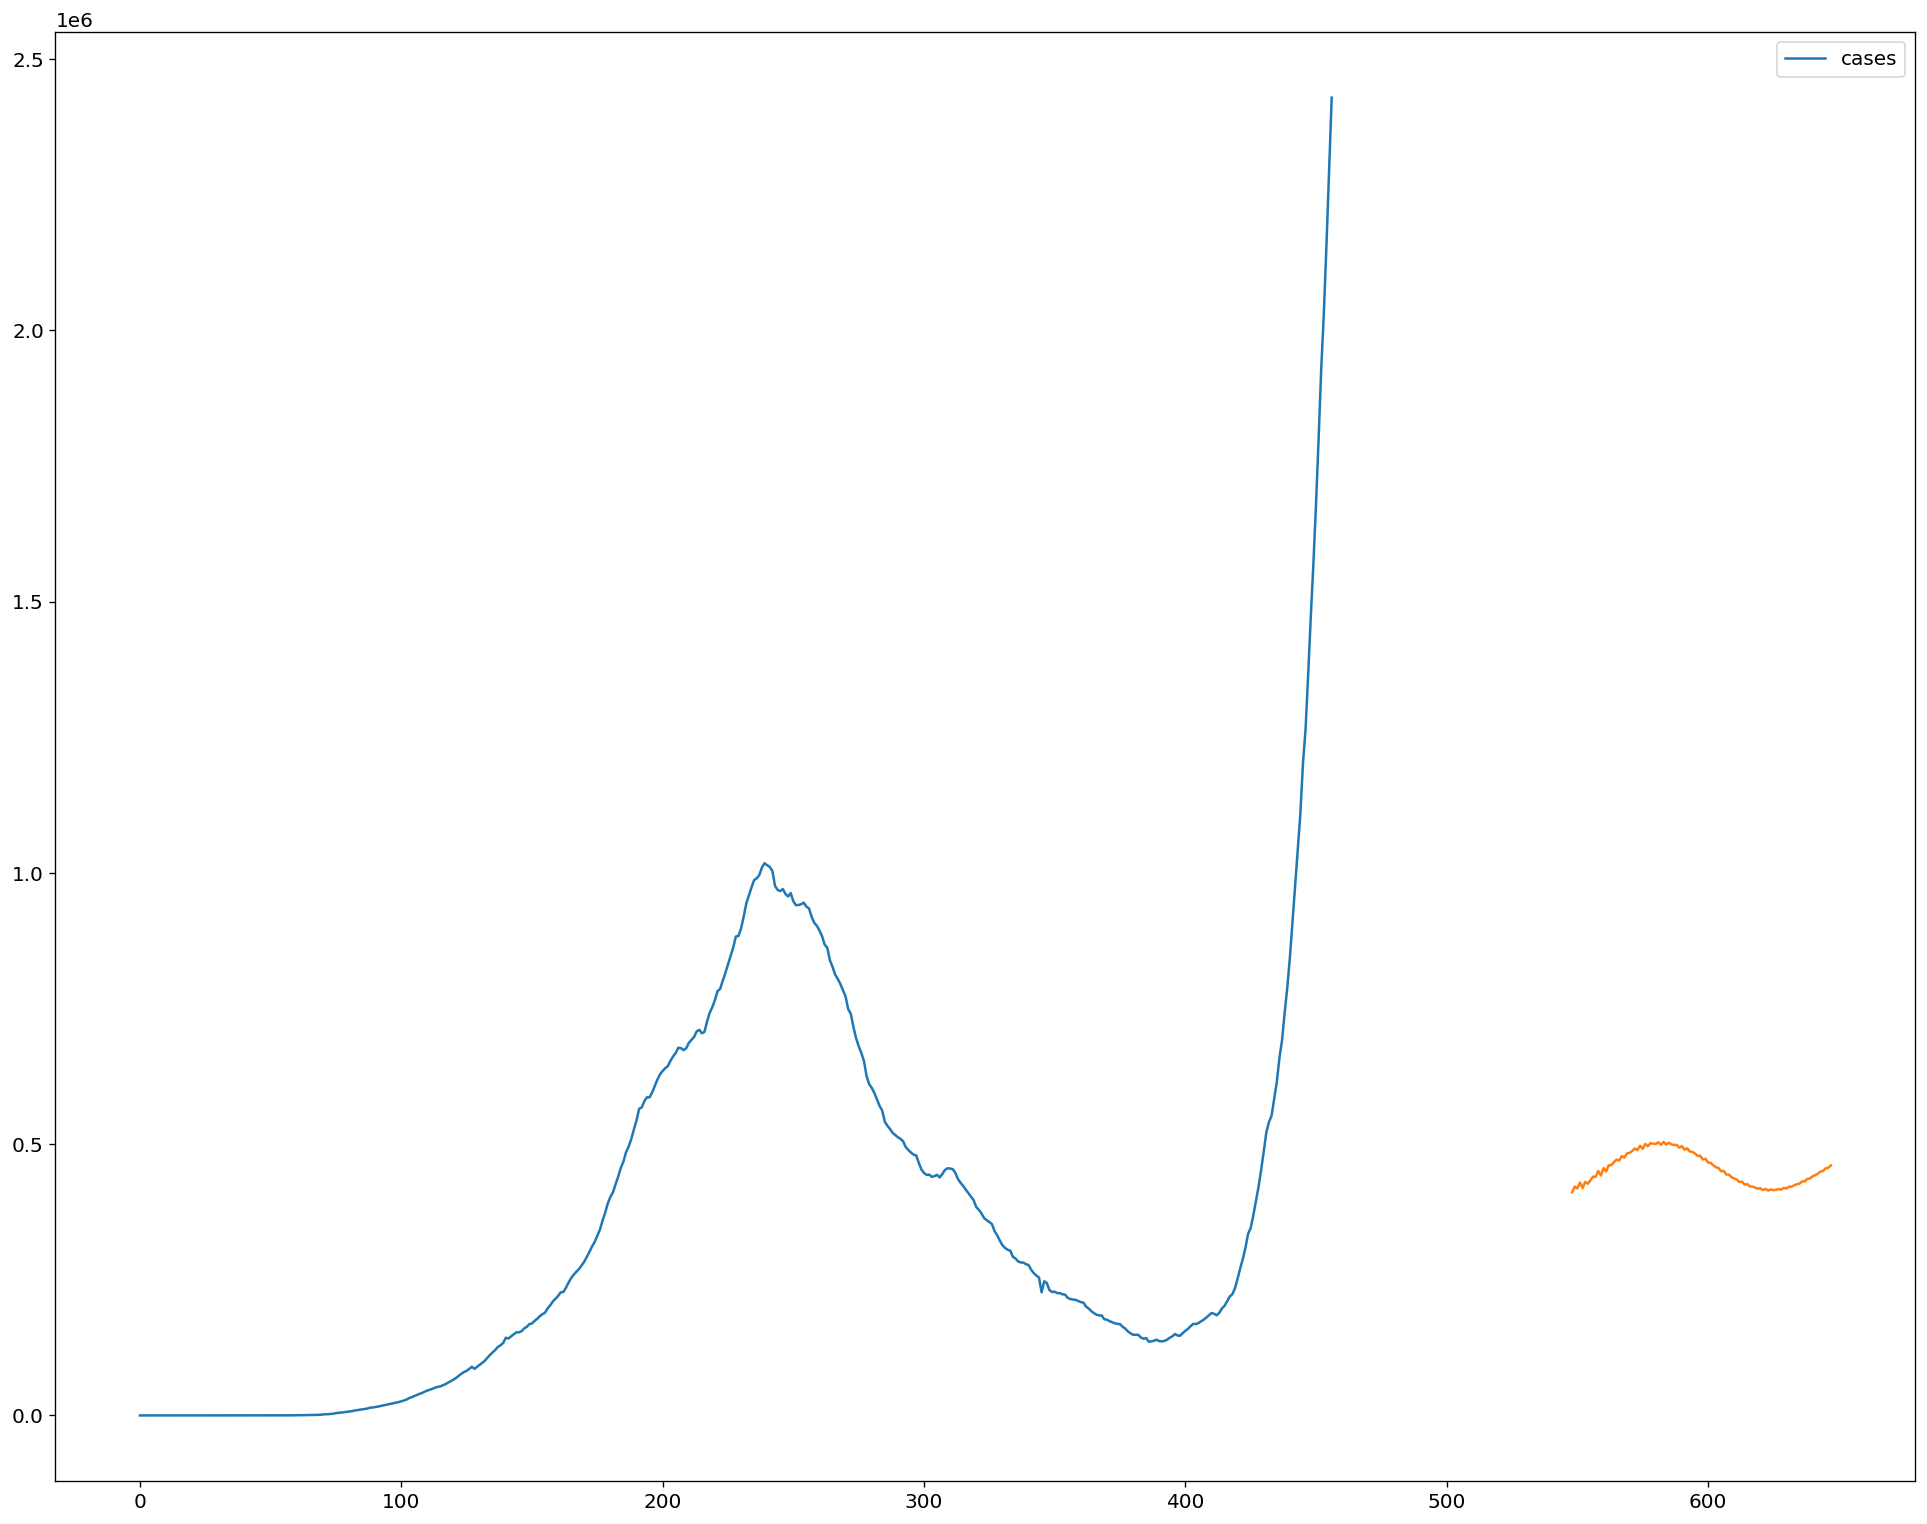

In [26]:
pred = results.get_forecast(100)
ax = testdf.plot(figsize=(20, 16))
pred.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')

In [27]:
print(
    f"The smallest MSE is {min(MSE)} for model ARIMA {ARIMA_model[MSE.index(min(MSE))][0]}x{ARIMA_model[MSE.index(min(MSE))][1]}"
)

NameError: name 'MSE' is not defined

In [ ]:
print(ARIMA_model)

In [ ]:
mod = sm.tsa.ARIMA(active_train['Worldwide'],
                                order=ARIMA_model[MSE.index(min(MSE))],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()